In [1]:
from functools import partial
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz, yr, h
from astropy.cosmology import LambdaCDM
import pandas as pd
from scipy.stats import truncnorm
from astropy.io import fits
from schwimmbad import MultiPool
from uncertainties import unumpy


from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission, BimodalPacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw, Calzetti2000, GrainsWD01
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
    O2b,
    O2r,
    O3r,
    O3b,
    O3,
)
from synthesizer.conversions import lnu_to_absolute_mag

np.random.seed(680010)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from utilities import binned_weighted_quantile, calc_line_corr

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)

In [2]:
def get_data(ii, tag, Muv_limit):

    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_connor.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('CurrentMassWeightedStellarZ'), dtype = np.float32)
        MFUVatt = lnu_to_absolute_mag(np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz)

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)

        OIII5007 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OIII5007'].get('Luminosity'), dtype = np.float64)
        OIII4959 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OIII4959'].get('Luminosity'), dtype = np.float64)
        OII3727 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OII3726'].get('Luminosity'), dtype = np.float64) + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OII3729'].get('Luminosity'), dtype = np.float64)
        NeIII3869 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/NeIII3869'].get('Luminosity'), dtype = np.float64)
        # + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI3889'].get('Luminosity'), dtype = np.float64) + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HeI3889'].get('Luminosity'), dtype = np.float64)

        OIII5007int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OIII5007'].get('Luminosity'), dtype = np.float64)
        OIII4959int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OIII4959'].get('Luminosity'), dtype = np.float64)
        OII3727int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OII3726'].get('Luminosity'), dtype = np.float64) + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OII3729'].get('Luminosity'), dtype = np.float64)
        NeIII3869int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/NeIII3869'].get('Luminosity'), dtype = np.float64)

    ok = (Halphaint>0) * (Mstar>1e8) * (MFUVatt<=Muv_limit) 

    return Mstar[ok], MFUVatt[ok], Halpha[ok], OIII5007[ok], OIII4959[ok], OII3727[ok], NeIII3869[ok], OIII5007int[ok], OIII4959int[ok], OII3727int[ok], NeIII3869int[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], Av[ok]

In [3]:
def plot_met_data(paper, ax):
    
    if paper=='rebels':
        data = fits.open('./data/REBELS_IFU_forAswin_dustcorr.fits')[1].data
        mstar = data['logMstar']
        mstar_up = data['logMstar_uerr'] - mstar
        mstar_lo = mstar - data['logMstar_lerr'] 
        met = data['metallicity']
        met_err = data['metallicity_err']
        
        ax.errorbar(mstar, met, xerr=[mstar_lo, mstar_up], yerr=met_err, marker='o', markersize=5, color='magenta', label='Rowland+2025', linestyle='None')
        
        
    if paper=='nakajima':
        obs_data = pd.read_excel('./data/Nakajima_2023.xlsx')
        obs_z = np.array(obs_data['Redshift'])[1:]
        obs_Muv = np.array(obs_data['Muv'])[1:]
        obs_Muverr = np.array(obs_data['err1_Muv'])[1:]
        obs_Mstar = np.array(obs_data['log_Mstar'])[1:]
        obs_Mstarerr = np.array(obs_data['err1_log_Mstar'])[1:]
        obs_logOH = np.array(obs_data['12+log(O/H)'])[1:]
        obs_logOHerr = np.array(obs_data['err1_log(O/H)'])[1:]
        
        ok = (6.5<obs_z) * (obs_z<7.5)
        
        x, y, xerr, yerr, c = obs_Mstar[ok], obs_logOH[ok], obs_Mstarerr[ok], obs_logOHerr[ok], obs_Muv[ok]
        xerr = xerr.astype(np.float32)
        yerr = yerr.astype(np.float32)
        xuplims, yuplims = np.zeros(len(x)), np.zeros(len(x))
        for ii in range(len(x)):

            if '<' in x[ii]:
                x[ii] = x[ii][1:]
                xuplims[ii] = 1
            
            # if '<' in y[ii]:
            #     y[ii] = y[ii][1:]
            #     yuplims[ii] = 1

            
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        # c = c.astype(np.float32)
        
        ok = x>8
        x, y, xerr, yerr, xuplims, yuplims = x[ok], y[ok], xerr[ok], yerr[ok], xuplims[ok], yuplims[ok] 
        
        ax.errorbar(x, y, xerr=xerr, yerr=yerr, xuplims=xuplims, uplims=yuplims, marker='s', markersize=5, label='Nakajima+2023', linestyle='None')
        
    if paper=='heintz':
        
        obs_Mstar       = np.array([8.84-np.log10(19.2), 8.19-np.log10(2.25), 8.72-np.log10(1.46), 9.05-np.log10(1.33), 8.88-np.log10(2.12), 8.45, 8.33, 8.66, 8.40, 10.0, 8.85, 9.05, 9.07, 9.47, 9.04, 8.64])
        obs_Mstar_up    = np.array([0.02, 0.08, 0.02, 0.06, 0.02, 0.03, 0.05, 0.02, 0.05, 0.01, 0.07, 0.03, 0.01, 0.04, 0.10, 0.05])
        obs_Mstar_low   = np.array([0.03, 0.06, 0.03, 0.05, 0.02, 0.02, 0.03, 0.02, 0.04, 0.01, 0.06, 0.02, 0.01, 0.06, 0.11, 0.05])
        obs_Z           = np.array([7.56, 7.29, 7.68, 7.30, 7.97, 7.82, 7.49, 7.42, 7.86, 8.06, 8.06, 7.55, 7.75, 8.00, 7.62, 7.42])
        obs_Z_up        = np.array([0.16, 0.22, 0.18, 1.00, 0.28, 0.18, 0.16, 0.18, 0.23, 0.17, 1.00, 0.21, 0.17, 0.29, 0.25, 0.19])
        obs_Z_low       = np.array([0.17, 0.28, 0.19, 0.01, 0.30, 0.20, 0.17, 0.18, 0.32, 0.17, 0.01, 0.27, 0.17, 0.34, 0.28, 0.20])
        
        ax.errorbar(obs_Mstar, obs_Z, xerr=[obs_Mstar_low, obs_Mstar_up], yerr=[obs_Z_low, obs_Z_up], marker='d', markersize=5, label='Heintz+2023', linestyle='None')
        
    return ax

def plot_rebels_data(dataset):
    
    data = fits.open('./data/REBELS_IFU_forAswin_nodustcorr.fits')[1].data
    
    return np.array(data[dataset])
    

In [4]:
# Modified code from Lucie Rowlands
import cmath
import warnings

# Sanders 2023 calibration functions

def quadratic_solution(a, b, c):
    """Solves a quadratic equation ax^2 + bx + c = 0."""
    discriminant = (b**2) - (4*a*c)
    if discriminant < 0:
        warnings.warn("Complex roots.")
        return None, None
    return (-b - cmath.sqrt(discriminant)) / (2*a), (-b + cmath.sqrt(discriminant)) / (2*a)

def Sanders23_O3(O3, Hbeta):
    O3_ratio = O3 / Hbeta
    sol1, sol2 = quadratic_solution(-0.453, -0.072, 0.834 - np.log10(O3_ratio))
    return (sol1 + 8, sol2 + 8) if sol1 and sol2 else (None, None)

def Sanders23_R23(o3_5007, o3_4959, o2, Hbeta):
    R23_ratio = (o3_5007 + o3_4959 + o2) / Hbeta
    sol1, sol2 = quadratic_solution(-0.331, 0.026, 1.017 - np.log10(R23_ratio))
    return (sol1 + 8, sol2 + 8) if sol1 and sol2 else (None, None)

def Sanders23_Ne3O2(Ne3, O2):
    """Convert Ne3O2 to Z"""
    
    return (np.log10(Ne3 / O2) + 0.386) / -0.998 + 8

def Sanders23_O32(O3, O2):
    """Convert O32 to metallicity"""
    
    return (np.log10(O3 / O2) - 0.723) / -1.153 + 8

def Z_to_O32(Z):
    """Convert metallicity to O32 ratio."""
    if Z is None:
        return None
    return 10**((Z - 8) * (-1.153) + 0.723)

def Z_to_Ne3O2(Z):
    """Convert metallicity to Ne3O2 ratio."""
    if Z is None:
        return None
    return 10**((Z - 8) * (-0.998) - 0.386)

def O32_to_Z(O32):
    """Convert O32 to metallicity"""
    
    x = (np.log10(O32) - 0.723)/(-1.153)
    
    return x + 8.0

def Ne3O2_to_Z(Ne3O2):
    """Convert Ne3O2 to Z"""

    x = (np.log10(Ne3O2) + 0.386)/(-0.998)
    
    return x + 8.0


def compute_metallicity_dust_correction(galaxy, dust=True):
    """Computes the metallicity for a given galaxy using
        balmer corrected fluxes for line ratios.
        Using OIII]5007, [OIII]4959, [OII]3727,29, Hbeta
    """
    metallicity, notes = None, ""
   
    # R23 = galaxy['R23']
    # R3 = galaxy['R3']
    # Ne3O2 = galaxy['Ne3O2']
    # O32 = galaxy['O32']
    Balmer_obs = galaxy['Halpha']/galaxy['Hbeta']
    
    if dust==True:
        galaxy_corr = {}
        galaxy_corr['[OIII]5007'] = calc_line_corr(galaxy['[OIII]5007'], 5006.84 * Angstrom, Balmer_obs)
        galaxy_corr['[OIII]4959'] = calc_line_corr(galaxy['[OIII]4959'], 4958.91 * Angstrom, Balmer_obs)
        galaxy_corr['Hbeta'] = calc_line_corr(galaxy['Hbeta'], 4861.32 * Angstrom, Balmer_obs)
        galaxy_corr['[OII]3727,29'] = calc_line_corr(galaxy['[OII]3727,29'], np.mean([3726.03, 3728.81]) * Angstrom, Balmer_obs)
        O32 = galaxy_corr['[OIII]5007']/galaxy_corr['[OII]3727,29']

    else:       
        galaxy_corr=galaxy
        O32=galaxy['O32']

    #O32 and R23 should only be used for corrected fluxes!!!
    #R3 and R23 give two metallicity solutions, an upper branch and a lower branch solution. We need to choose between them

    Z_high, Z_low = Sanders23_R23(galaxy_corr['[OIII]5007'], galaxy_corr['[OIII]4959'], galaxy_corr['[OII]3727,29'], galaxy['Hbeta'])
    pred_O32_high, pred_O32_low = Z_to_O32(Z_high), Z_to_O32(Z_low)

    #Which metallicity solution, upper or lower branch, should we use?
    #For each metallicity, calculate the corresponding O32 ratio, and then determine which is closest to the observed O32 ratio
    if Z_high and Z_low:
        metallicity = Z_high if abs(np.log10(pred_O32_high) - np.log10(O32)) < abs(np.log10(pred_O32_low) - np.log10(O32)) else Z_low
        notes = 'R23, high branch' if metallicity == Z_high else 'R23, low branch'
    if isinstance(metallicity, complex) or metallicity is None:
        metallicity = Sanders23_O32(O3=galaxy_corr['[OIII]5007'], O2=galaxy_corr['[OII]3727,29'])
        notes = 'O32'
    
    return metallicity, notes


def compute_metallicity_nodust_correction(galaxy):
    """Computes the metallicity for a given galaxy.
        This uses line ratios which are close in wavelength
        so that dust effects are considered to be negligible.
        Using R3 and Ne3O2 values
    """
    metallicity, notes = None, ""
    
    # R23 = galaxy['R23']
    # R3 = galaxy['R3']
    Ne3O2 = galaxy['Ne3O2']
    O32 = galaxy['O32']

    
    #When we don't have H-alpha, use un-corrected catalogue, and use only R3 and Ne3O2, since they are closer in wavelength so attenuation is less of a concern
   
    Z_high, Z_low = Sanders23_O3(galaxy['[OIII]5007'], galaxy['Hbeta'])
    pred_Ne3O2_high, pred_Ne3O2_low = Z_to_Ne3O2(Z_high), Z_to_Ne3O2(Z_low)

    if Z_high is not None and Z_low is not None:
        # pred_O32_high, pred_O32_low = Z_to_O32(Z_high), Z_to_O32(Z_low)

        if pred_Ne3O2_high is not None and pred_Ne3O2_low is not None:
            metallicity = Z_high if abs(np.log10(pred_Ne3O2_high) - np.log10(Ne3O2)) < abs(np.log10(pred_Ne3O2_low) - np.log10(Ne3O2)) else Z_low
            notes = 'R3, high branch' if metallicity == Z_high else 'R23, low branch'
        else:
            metallicity = Sanders23_Ne3O2(Ne3=galaxy['NeIII3869'], O2=galaxy['[OII]3727,29'])
            notes = 'Ne3O2'
        # if pred_O32_high is not None and pred_O32_low is not None:
        #         metallicity = Z_high if abs(np.log10(pred_O32_high) - np.log10(O32)) < abs(np.log10(pred_O32_low) - np.log10(O32)) else Z_low
        #         notes = 'R3, high branch' if metallicity == Z_high else 'R23, low branch'
        # else:
        #     metallicity = Sanders23_O32(O3=galaxy['[OIII]5007'], O2=galaxy['[OII]3727,29'])
        #     notes = 'O32'
    if isinstance(metallicity, complex) or metallicity is None:
        metallicity =  Sanders23_Ne3O2(Ne3=galaxy['NeIII3869'], O2=galaxy['[OII]3727,29'])
        notes = 'Ne3O2'  
    

    return metallicity, notes

    

def compute_Izotov_Z(galaxy, dust=True):
    """Computes the metallicity for a given galaxy using
        balmer corrected fluxes for line ratios.
        Using OIII]5007, [OIII]4959, [OII]3727,29, Hbeta
    """
    
    Balmer_obs = galaxy['Halpha']/galaxy['Hbeta']
    
    if dust==True:
        galaxy_corr = {}
        galaxy_corr['[OIII]5007'] = calc_line_corr(galaxy['[OIII]5007'], 5006.84 * Angstrom, Balmer_obs)
        galaxy_corr['[OIII]4959'] = calc_line_corr(galaxy['[OIII]4959'], 4958.91 * Angstrom, Balmer_obs)
        galaxy_corr['Hbeta'] = calc_line_corr(galaxy['Hbeta'], 4861.32 * Angstrom, Balmer_obs)
        galaxy_corr['[OII]3727,29'] = calc_line_corr(galaxy['[OII]3727,29'], np.mean([3726.03, 3728.81]) * Angstrom, Balmer_obs)
        R23 = (galaxy_corr['[OIII]5007'] + galaxy_corr['[OIII]4959'] + galaxy_corr['[OII]3727,29'])/galaxy_corr['Hbeta']
        O32 = galaxy_corr['[OIII]5007']/galaxy_corr['[OII]3727,29']

    else:       
        galaxy_corr=galaxy
        R23 = galaxy['R23']
        O32 = galaxy['O32']
    
    R23 = float(R23)
    O32 = float(O32)
        
    Z =  0.950 * np.log10(R23 - 0.08 * O32) + 6.805
    
    return Z

In [5]:
# Define the grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
# "bpass-2.2.1-bin_chabrier03-0.1,100.0_cloudy-c23.01-sps_U_2_n_3"
# "bpass-2.2.1-bin_chabrier03-0.1,300.0-ages_6.,7.,8._cloudy-c23.01-sps-no_grains"#"bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/" #"../synthesizer/synthesizer/tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869'
}
tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}
filters = FilterCollection(
    filter_codes=[f'Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

li = [
       Ha,
       Hb, 
       O2b,
       O2r,
       O3r,
       O3b,
       O3,
       'Ne 3 3868.76A'
   ]

In [6]:
redshift = 6.
# Number of star particles
n = 100
ages = np.random.uniform(1, 30, size=n) * Myr
Z = 10**np.random.uniform(-3, -2, size=n)
mass = 1e6*np.random.uniform(1, 5, n) * Msun 

# Dust distributions
max_tau = 15
mu, sigma = 0.1, 0.2
nsigma = np.arange(0,max_tau,2)
num_gals = len(nsigma)


# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
Av = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

print (Zmean, Agemean)

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

for jj, kk in enumerate(all_gals):

    print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):
        tau_v = mu + np.random.normal(0, nsigma[ii], n)
        tau_v[tau_v<0] = 0.01
        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v,
            dust_curve=PowerLaw(),
            per_particle=True
        )    
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )        
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        lum_att[jj][ii] = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']
    
    sed_int[jj] = kk.stars.spectra['intrinsic']
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']
    line_int[jj] = kk.stars.lines['intrinsic']

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])
    
print (Av)

/Users/ap629AA/Astro/synthesizer/synthesizer/src/synthesizer/particle/galaxy.py:260: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


0.0043673333344749635 dimensionless 5268099.2695223 yr
Galaxy number:  0
Galaxy number:  1
Galaxy number:  2
Galaxy number:  3


/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


[[0.11232316 0.37626865 0.57443586 0.68736729 0.81576991 0.55356865
  0.62897995 0.82225813]
 [0.11248481 0.40804627 0.58137391 0.41192993 0.71075048 0.46535186
  0.85671071 1.03117474]
 [0.11171944 0.39539183 0.42554593 0.63345198 0.77923008 0.64041277
  0.55721017 0.71498613]
 [0.11223307 0.58171346 0.56929002 0.62227711 0.47984793 0.56501871
  0.59748017 0.33762594]]


# Line ratios

$S2 = [SII]\lambda 6716,31 / H_{\alpha}$

$R3 = [OIII]\lambda 5007/ H_{\beta}$

$R2 = [OII]\lambda 3727,29/H_{\beta}$

$R23 = \dfrac{[OIII]\lambda 4959,5007 + [OII]\lambda 3727,29}{H_{\beta}}$

$O32 = [OIII]\lambda5007/[OII]\lambda3727,29$

$Ne3O2 = [NeIII]\lambda3869/[OII]\lambda 3727,29$

<>:102: SyntaxWarning: invalid escape sequence '\m'
<>:102: SyntaxWarning: invalid escape sequence '\m'
<>:102: SyntaxWarning: invalid escape sequence '\m'
<>:102: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_3826/1807567026.py:102: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=12, loc="lower right")
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_3826/1807567026.py:102: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=12, loc="lower right")


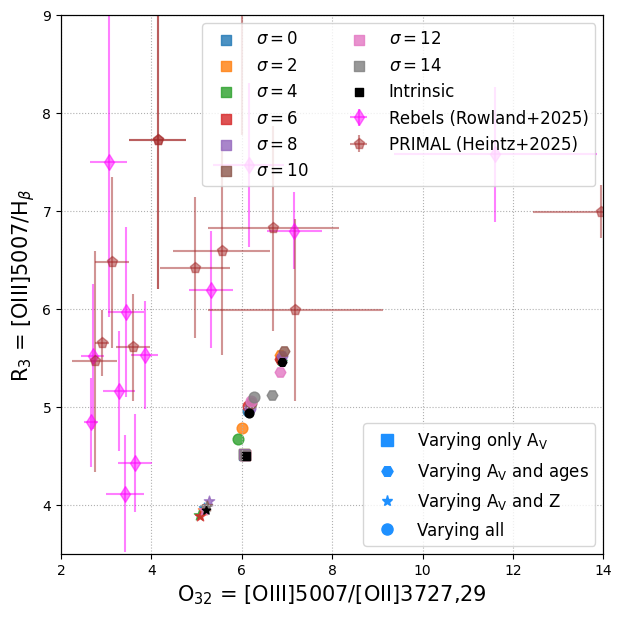

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), sharex=True, sharey=True, facecolor='w', edgecolor='k')
twinax = ax.twinx()

line_gals_int, line_gals_att = {}, {}

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

for jj, kk in enumerate(all_gals):
    
    tmp = {value: line_int[jj][key].luminosity.sum() for key, value in req_lines.items()}
    tmp['R23'] = (tmp['[OIII]4959']+tmp['[OIII]5007']+tmp['[OII]3727,29'])/tmp['Hbeta']
    tmp['R3'] = tmp['[OIII]5007']/tmp["Hbeta"]
    tmp['Ne3O2'] = tmp['NeIII3869']/tmp['[OII]3727,29']
    tmp['O32'] = tmp['[OIII]5007']/tmp['[OII]3727,29']
    
    Ha_int      = line_int[jj]['H 1 6562.80A'].luminosity.sum()
    Hb_int      = line_int[jj]['H 1 4861.32A'].luminosity.sum()
    O2b_int     = line_int[jj]['O 2 3726.03A'].luminosity.sum()
    O2r_int     = line_int[jj]['O 2 3728.81A'].luminosity.sum()
    O2_int      = O2b_int + O2r_int
    O3b_int     = line_int[jj]['O 3 4958.91A'].luminosity.sum()
    O3r_int     = line_int[jj]['O 3 5006.84A'].luminosity.sum()
    O3_int      = line_int[jj]['O 3 4958.91A,O 3 5006.84A'].luminosity.sum()

    if jj==0:
        line_gals_int = {jj: tmp}    
    else:
        line_gals_int[jj] = tmp   

    for ii in range(num_gals):
        color = plt.cm.tab10(ii)   

        Ha      = line_emergent[jj][ii]['H 1 6562.80A'].luminosity.sum()
        Hb      = line_emergent[jj][ii]['H 1 4861.32A'].luminosity.sum()
        O2b     = line_emergent[jj][ii]['O 2 3726.03A'].luminosity.sum()
        O2r     = line_emergent[jj][ii]['O 2 3728.81A'].luminosity.sum()
        O2      = O2b + O2r
        O3b     = line_emergent[jj][ii]['O 3 4958.91A'].luminosity.sum()
        O3r     = line_emergent[jj][ii]['O 3 5006.84A'].luminosity.sum()
        O3      = line_emergent[jj][ii]['O 3 4958.91A,O 3 5006.84A'].luminosity.sum()  
        
        tmp = {value: line_emergent[jj][ii][key].luminosity.sum() for key, value in req_lines.items()}
        tmp['R23'] = (tmp['[OIII]4959']+tmp['[OIII]5007']+tmp['[OII]3727,29'])/tmp['Hbeta']
        tmp['R3'] = tmp['[OIII]5007']/tmp["Hbeta"]
        tmp['Ne3O2'] = tmp['NeIII3869']/tmp['[OII]3727,29']
        tmp['O32'] = tmp['[OIII]5007']/tmp['[OII]3727,29']
        tmp['R2'] = tmp['[OII]3727,29']/tmp["Hbeta"]
        if ii==0:
            line_gals_att[jj] = {ii: tmp}    
        else:
            line_gals_att[jj][ii] = tmp        
        
        if jj==0:
            ax.scatter((O3r+O2)/Hb, O3r/Hb, color=color, label=rF'$\sigma={nsigma[ii]}$', s=60, marker=markers[jj], alpha=0.8)
        else:
            ax.scatter((O3r+O2)/Hb, O3r/Hb, color=color, s=60, marker=markers[jj], alpha=0.8)
            
    if jj==0:
        ax.scatter((O3r_int+O2_int)/Hb_int, O3r_int/Hb_int, color='black', label='Intrinsic', marker=markers[jj], s=40)
    else:
        ax.scatter((O3r_int+O2_int)/Hb_int, O3r_int/Hb_int, color='black', marker=markers[jj], s=40)        

obs_OIII = unumpy.uarray(plot_rebels_data('[OIII]5007_flux'), plot_rebels_data('[OIII]5007_flux_error'))
obs_OII = unumpy.uarray(plot_rebels_data('[OII]3727,29_flux'), plot_rebels_data('[OII]3727,29_flux_error'))
obs_Hb = unumpy.uarray(plot_rebels_data('H-beta_flux'), plot_rebels_data('H-beta_flux_error'))

obs_x = obs_OIII/obs_OII
obs_y = obs_OIII/obs_Hb

ax.errorbar(unumpy.nominal_values(obs_x), unumpy.nominal_values(obs_y), xerr=unumpy.std_devs(obs_x), yerr=unumpy.std_devs(obs_y), label='Rebels (Rowland+2025)', color='magenta', marker='d', ls='None', alpha=0.5, markersize=8)

df = pd.read_csv('./data/JWSTPRIMAL_All_red.csv', delimiter=';')
df = df.dropna()

obs_OIII = unumpy.uarray(df['OIII_5008'], df['err_OIII_5008'])
obs_OII = unumpy.uarray(df['OII_3727'], df['err_OII_3727'])
obs_Hb = unumpy.uarray(df['Hbeta'], df['err_Hbeta'])

obs_x = obs_OIII/obs_OII
obs_y = obs_OIII/obs_Hb

ok = np.where(unumpy.std_devs(obs_x)<2)[0]#np.random.randint(0, len(obs_x), 20)
obs_x = obs_x[ok]
obs_y = obs_y[ok]
ok = np.random.randint(0, len(obs_x), 15)
obs_x = obs_x[ok]
obs_y = obs_y[ok]

ax.errorbar(unumpy.nominal_values(obs_x), unumpy.nominal_values(obs_y), xerr=unumpy.std_devs(obs_x), yerr=unumpy.std_devs(obs_y), label='PRIMAL (Heintz+2025)', color='brown', marker='p', ls='None', alpha=0.5, markersize=8)

ax.legend(fontsize=12, ncols=2, loc='upper right') 

ax.set_xlabel(r'O$_{32}$ = [OIII]5007/[OII]3727,29', fontsize=15)
ax.set_ylabel(r'R$_{3}$ = [OIII]5007/H$_{\beta}$', fontsize=15)
ax.set_xlim(2,14)
ax.set_ylim(3.5,9)
ax.grid(ls='dotted')
twinax.set_yticks([])
twinax.set_yticklabels([])

twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=12, loc="lower right")

plt.savefig('plots/toy_R3_O32.png', dpi=300, bbox_inches='tight')   
plt.show()

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_3826/1986192600.py:47: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=12, loc=(0.01,1.1), ncols=2, framealpha=0.4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_3826/1986192600.py:47: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=12, loc=(0.01,1.1), ncols=2, framealpha=0.4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_3826/2060243286.py:11: UserWarning: Complex roots.
  warn

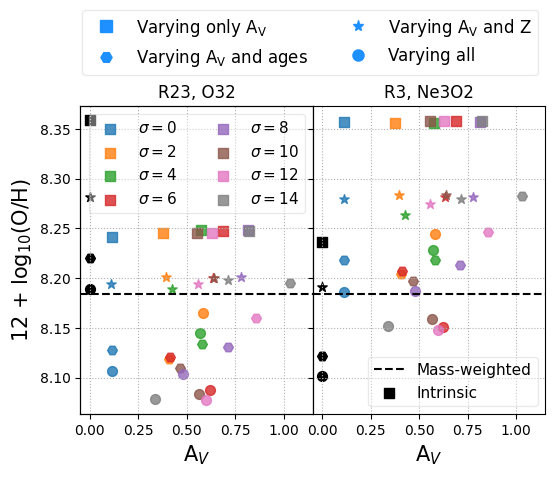

In [8]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(6, 4), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()
twinax = axs[0].twinx()

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

axs[0].axhline(y=logOH[0], color='black', ls='dashed')
axs[1].axhline(y=logOH[0], label='Mass-weighted', color='black', ls='dashed')

for jj in range(4):
    
    if jj==0:
        axs[0].scatter(0.0, compute_metallicity_nodust_correction(line_gals_int[jj])[0], color='black', s=50, marker=markers[jj])
        axs[1].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[jj], dust=False)[0], color='black', s=50, marker=markers[jj], label='Intrinsic')

    else:
        axs[0].scatter(0.0, compute_metallicity_nodust_correction(line_gals_int[jj])[0], color='black', s=50, marker=markers[jj])
        axs[1].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[jj], dust=False)[0], color='black', s=50, marker=markers[jj])

    
    for ii in range(num_gals):
        color = plt.cm.tab10(ii)
        
        if jj==0:
            axs[0].scatter(Av[jj][ii], compute_metallicity_dust_correction(line_gals_att[jj][ii])[0], color=color, s=50, marker=markers[jj], alpha=0.8, label=rF'$\sigma={nsigma[ii]}$')

        else:
            axs[0].scatter(Av[jj][ii], compute_metallicity_dust_correction(line_gals_att[jj][ii])[0], color=color, s=50, marker=markers[jj], alpha=0.8)
        
        axs[1].scatter(Av[jj][ii], compute_metallicity_nodust_correction(line_gals_att[jj][ii])[0], color=color, s=50, marker=markers[jj], alpha=0.8)
        

for ax in axs:
    ax.set_xlabel(r'A$_{V}$', fontsize=15)
    # ax.set_ylim(7.95,8.3)
    ax.grid(ls='dotted')
     
    twinax.set_yticks([])
    twinax.set_yticklabels([])
    ax.set_xlim(-0.05, 1.15)

axs[0].legend(frameon=True, fontsize=11, ncols=2, loc='upper right', framealpha=0.4)
axs[1].legend(frameon=True, fontsize=11, ncols=1, loc='lower right', framealpha=0.4)

axs[0].set_ylabel(r'12 + log$_{10}$(O/H)', fontsize=15)
twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=12, loc=(0.01,1.1), ncols=2, framealpha=0.4)
axs[0].set_title('R23, O32', fontsize=12)
axs[1].set_title('R3, Ne3O2', fontsize=12)

fig.subplots_adjust(hspace=0,wspace=0)

plt.savefig('plots/toy_met_Av.png', dpi=300, bbox_inches='tight')
plt.show()   

In [9]:
compute_Izotov_Z(line_gals_int[3], dust=False)

np.float64(7.636354177984668)

In [10]:
def flares_galaxies(ii, func, data):
    
    Halpha, Hbeta, OII3727, OIII4959, OIII5007, NeIII3869 = data
    
    gal = {}
    gal['Halpha'] = Halpha[ii]
    gal['Hbeta'] = Hbeta[ii]
    gal['[OII]3727,29'] = OII3727[ii]
    gal['[OIII]4959'] = OIII4959[ii]
    gal['[OIII]5007'] = OIII5007[ii]
    gal[ 'NeIII3869'] = NeIII3869[ii]
    
    gal['R23'] = (gal['[OIII]4959']+gal['[OIII]5007']+gal['[OII]3727,29'])/gal['Hbeta']
    gal['R3'] = gal['[OIII]5007']/gal["Hbeta"]
    gal['R2'] = gal['[OII]3727,29']/gal["Hbeta"]
    gal['Ne3O2'] = gal['NeIII3869']/gal['[OII]3727,29']
    gal['O32'] = gal['[OIII]5007']/gal['[OII]3727,29']
    
    out = func(gal)
    
    return out

def get_flares_galZ(data_att, data_int, tot_gals):    
   
    flares_dust_corr_Z = np.array([flares_galaxies(ii, compute_metallicity_dust_correction, data_att) for ii in range(tot_gals)])[:,0]
    flares_nodust_corr_Z = np.array([flares_galaxies(ii, compute_metallicity_nodust_correction, data_att) for ii in range(tot_gals)])[:,0]

    flares_int_nodust_corr_Z = np.array([flares_galaxies(ii, compute_metallicity_nodust_correction, data_int) for ii in range(tot_gals)])[:,0]
    f = partial(compute_metallicity_dust_correction, dust=False)
    flares_int_dust_corr_Z = np.array([flares_galaxies(ii, f, data_int) for ii in range(tot_gals)])[:,0]
    
    return np.asarray(flares_dust_corr_Z, dtype=np.float32), np.asarray(flares_nodust_corr_Z, dtype=np.float32), np.asarray(flares_int_dust_corr_Z, dtype=np.float32), np.asarray(flares_int_nodust_corr_Z, dtype=np.float32)

In [ ]:
Muv_limit = -19
df = pd.read_csv('./data/weights_grid.txt')
weights = np.array(df['weights'])

tags = ['010_z005p000', '009_z006p000', '008_z007p000', '007_z008p000', '006_z009p000', '005_z010p000']
tag = tags[1]

# a = find_metallicity(R23=9.9, R3=7.2, O32=18.6, hbew=151)

z = float(tag[5:].replace('p','.'))

func    = partial(get_data, tag=tag, Muv_limit=Muv_limit)
pool    = MultiPool(processes=4)
dat     = np.array(list(pool.map(func, np.arange(0,40))), dtype='object')
pool.close()

data_att = {}

Mstar = np.log10(np.concatenate(dat[:,0]))
MFUVatt = np.concatenate(dat[:,1])
Halpha = np.concatenate(dat[:,2])
OIII5007 = np.concatenate(dat[:,3])
OIII4959 = np.concatenate(dat[:,4])
OII3727 = np.concatenate(dat[:,5])
NeIII3869 = np.concatenate(dat[:,6])
OIII5007int = np.concatenate(dat[:,7])
OIII4959int = np.concatenate(dat[:,8])
OII3727int = np.concatenate(dat[:,9])
NeIII3869int = np.concatenate(dat[:,10])
Hbeta = np.concatenate(dat[:,11])
Halphaint = np.concatenate(dat[:,12])
Hbetaint = np.concatenate(dat[:,13])
MassweightedZ = 8.69 + np.log10(np.concatenate(dat[:,14])/Zsun)

tot_gals = len(Mstar)

data_att = (Halpha, Hbeta, OII3727, OIII4959, OIII5007, NeIII3869)
data_int = (Halphaint, Hbetaint, OII3727int, OIII4959int, OIII5007int, NeIII3869int)

flares_dust_corr_Z, flares_nodust_corr_Z, flares_int_dust_corr_Z, flares_int_nodust_corr_Z = get_flares_galZ(data_att, data_int, tot_gals)

ws = np.zeros(len(Mstar))
n = 0
for jj in range(40):
    if jj==0:
        ws[0:len(dat[jj][0])] = weights[jj]
    else:
        ws[n:n+len(dat[jj][0])] = weights[jj]

    n+=len(dat[jj][0])

# fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6, 6), sharex=False, sharey=False, facecolor='w', edgecolor='k')

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_3826/3305203817.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_3826/3305203817.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvq

In [21]:
quantiles = [0.16,0.50,0.84]
mbins = np.arange(8,11,0.5)
mbincen = (mbins[1:] + mbins[:-1])/2.
yy, yy_low, yy_up = np.zeros((6, len(mbincen))), np.zeros((6, len(mbincen))), np.zeros((6, len(mbincen)))

tmp = binned_weighted_quantile(Mstar, flares_dust_corr_Z, ws, mbins, quantiles)
yy[0], yy_low[0], yy_up[0] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, flares_int_dust_corr_Z, ws, mbins, quantiles)
yy[1], yy_low[1], yy_up[1] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, flares_nodust_corr_Z, ws, mbins, quantiles)
yy[2], yy_low[2], yy_up[2] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, flares_int_nodust_corr_Z, ws, mbins, quantiles)
yy[3], yy_low[3], yy_up[3] = tmp[:,1], tmp[:,0], tmp[:,2]

tmp = binned_weighted_quantile(Mstar, MassweightedZ, ws, mbins, quantiles)
yy[4], yy_low[4], yy_up[4] = tmp[:,1], tmp[:,0], tmp[:,2]

<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_3826/1002445045.py:31: SyntaxWarning: invalid escape sequence '\s'
  axs[0].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_3826/1002445045.py:32: SyntaxWarning: invalid escape sequence '\s'
  axs[1].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)


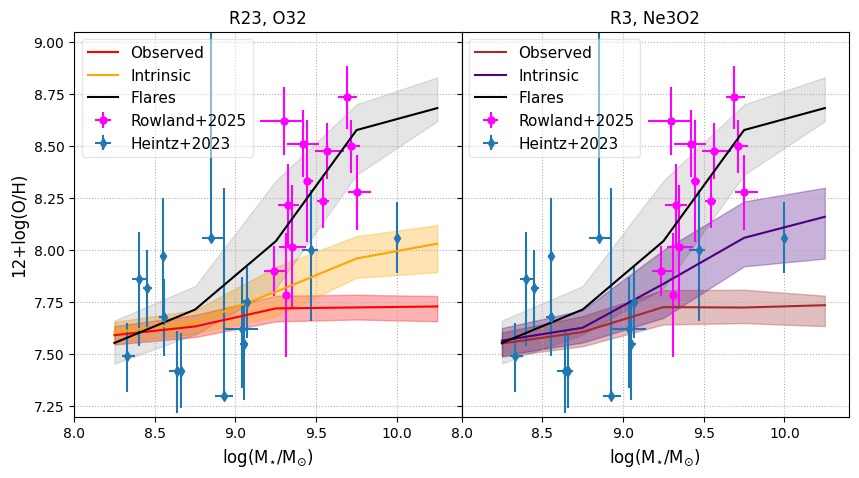

In [23]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs=axs.ravel()

labels = ['Observed', 'Intrinsic', 'Observed', 'Intrinsic', 'Flares']

colors = ['red', 'orange', 'brown', 'indigo', 'black', 'grey']

for jj in range(2):
    # plot_met_data('nakajima', axs[jj])
    plot_met_data('rebels', axs[jj])
    plot_met_data('heintz', axs[jj])


    axs[jj].plot(mbincen, yy[2*jj], label=labels[2*jj], color=colors[2*jj])
    axs[jj].fill_between(mbincen, yy_low[2*jj], yy_up[2*jj], color=colors[2*jj], alpha=0.3)
    
    axs[jj].plot(mbincen, yy[2*jj+1], label=labels[2*jj+1], color=colors[2*jj+1])
    axs[jj].fill_between(mbincen, yy_low[2*jj+1], yy_up[2*jj+1], color=colors[2*jj+1], alpha=0.3)
    
    axs[jj].plot(mbincen, yy[4], label=labels[4], color=colors[4])
    axs[jj].fill_between(mbincen, yy_low[4], yy_up[4], color=colors[4], alpha=0.1)
    
    
    axs[jj].legend(fontsize=11, frameon=True, framealpha=0.5)
    axs[jj].grid(ls='dotted')
    axs[jj].set_xlim(8, 10.4)
    axs[jj].set_ylim(7.2, 9.05)
    
axs[0].set_ylabel('12+log(O/H)', fontsize=12)  
    
axs[0].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)
axs[1].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=12)

axs[0].set_title('R23, O32', fontsize=12)
axs[1].set_title('R3, Ne3O2', fontsize=12)
    
fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('plots/line_ratio_mzr.png', dpi=300, bbox_inches='tight')

In [14]:
np.sum(np.isnan(flares_dust_corr_Z))

np.int64(0)